In [1]:
import  numpy  as  np
import libpysal as ps
from stwr.gwr import GWR, MGWR,STWR
from stwr.sel_bw import *
from stwr.utils import shift_colormap, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math
from matplotlib.gridspec import GridSpec
import time
import csv 
import copy

In [2]:
def procedure(second =1):
    time.sleep(second) 

In [3]:
#1.Data  generating process (DGP) for initial three different heterogenity during the time in the space.

beta = np.ones([3,25,25])
beta[0] = 3*beta[0]
for i in range(25) :
            for j in range(25):
                beta[1,i,j] = 1+(i+j)/12
for i in range(25) :
            for j in range(25):
                beta[2,i,j] = 1 +(36- (6- i/2)**2)*(36- (6- j/2)**2)/324

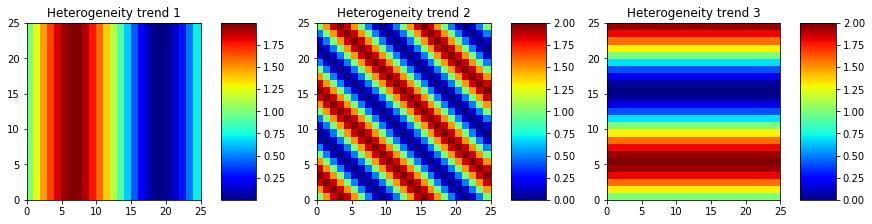

In [4]:
#2.Define three type of heterogeneity trend functions#
#draw the three trend surfaces#

values_change_dwr = np.ones([3,25,25])
def Values_change_trend(values_change_trend,changecase,cur_tick=0, deta_t = 1,sita = 1,power = 1):
            if (changecase == 0):
              for i in range(25) :
                for j in range(25):
                    values_change_trend[cur_tick,i,j] = values_change_trend[cur_tick,i,j] + sita*1*math.sin((j/4))*deta_t**power
            elif(changecase == 1):
                    for i in range(25) :
                        for j in range(25):
                            values_change_trend[cur_tick,i,j] =values_change_trend[cur_tick,i,j] + sita*1*math.sin(1/10*np.pi*(i))*deta_t**power
            elif (changecase == 2):
                    for i in range(25) :
                            for j in range(25):
                                #dwr_change_trend[2,i,j] = 1+(36- (6- i/2)**2)*(36- (6- j/2)**2)/324
                                values_change_trend[cur_tick,i,j] = values_change_trend[cur_tick,i,j] + sita*1*math.sin(1/6*np.pi*(j+i))*deta_t**power            
Values_change_trend(values_change_dwr,0,0)
Values_change_trend(values_change_dwr,1,2)
Values_change_trend(values_change_dwr,2,1)

tred_max = [np.amax(values_change_dwr[0]),np.amax(values_change_dwr[1]),np.amax(values_change_dwr[2])]
tred_min = [np.amin(values_change_dwr[0]),np.amin(values_change_dwr[1]),np.amin(values_change_dwr[2])]
#####Generate the change thrend and draw #####          
fig_tred = plt.figure(figsize=(12,3),constrained_layout=True)
gs_tred = GridSpec(1, 3, figure=fig_tred)
jet_tred  = plt.get_cmap('jet',256)     
for col in range(3):
    str_ctv = "Heterogeneity trend {:d}".format(col+1)
    ax_tred = fig_tred.add_subplot(gs_tred[0,col],title =str_ctv )
    psm_tred = ax_tred.pcolormesh(values_change_dwr[col], cmap=jet_tred, rasterized=True, vmin=tred_min[col], vmax=tred_max[col])
    fig_tred.colorbar(psm_tred, ax = ax_tred)
plt.show()

In [5]:
#Define the beta change through time# 
def betavaluechange(onebeta,timeintervel=1,sita=1,pchange=0,power = 1):
    result_beta = np.ones_like(onebeta)
    if power ==0:
        result_beta = onebeta
        return result_beta
    elif (pchange == 0):
       for i in range(25):
           for j in range(25):
#               result_beta[i,j] = onebeta[i,j]+timeintervel**power*sita
                   result_beta[i,j] = onebeta[i,j]+0.2*math.sin((j/4))**power*sita
       return result_beta
    elif (pchange == 1):
        for i in range(25):
               for j in range(25):
#                   result_beta[i,j] = onebeta[i,j]+timeintervel**power*sita*(i+j)/12
                    result_beta[i,j] = onebeta[i,j]+ 0.2*math.sin(1/10*np.pi*(i))**power*sita
        return result_beta
    elif (pchange == 2):
        for i in range(25):
               for j in range(25):
                    result_beta[i,j] = onebeta[i,j]+ 0.2*math.sin(1/6*np.pi*(j+i))**power*sita
#                   result_beta[i,j] = onebeta[i,j]+timeintervel**power*sita*(36- (6- i/2)**2)*(36- (6- j/2)**2)/324
        return result_beta
    else: 
        raise print(' None supported')
        return result_beta

In [6]:
#Define the beta change through time# 
#Generate Betas surfaces throught time
kticks = 5
tick_times = np.ones((kticks,1))
for i in range(kticks):
     procedure(0.001)
     tick_times[i] = 10000*time.time()    
tick_times_intervel = np.ones((kticks,1))
delt_stwr_intervel = np.zeros((kticks,1))
tick_time_val = tick_times[0] 

for i in range(kticks):
     tick_times_intervel[i] = tick_times[i]-tick_times[0]
     delt_tick = tick_times[i]-tick_time_val
     tick_time_val = tick_times[i]
     delt_stwr_intervel[i] =delt_tick                  
beta_change = np.ones([kticks,3,25,25]);
beta_min_list =  []
beta_max_list =  []

beta_tick =beta.copy()

In [7]:
for i in range(kticks):
    #case1 and case2 beta surfaces not change over time 
    beta_change[i,0]= betavaluechange(beta_tick[0],tick_times_intervel[i],1,0,0) 
    beta_change[i,1]= betavaluechange(beta_tick[1],tick_times_intervel[i],1,2,0) 
    beta_change[i,2]= betavaluechange(beta_tick[2],tick_times_intervel[i],1,1,0)
    #case1 and case2 beta not change over time     
    beta_tick[0] = beta_change[i,0]
    beta_tick[1] = beta_change[i,1]
    beta_tick[2] = beta_change[i,2]   
    #record the min and max value for draw the pics later.
    beta_min_list.append(int(np.amin(beta_change[i])))
    beta_max_list.append(math.ceil(np.amax(beta_change[i])))                     
beta_min = np.amin(beta)
beta_max = np.amax(beta)

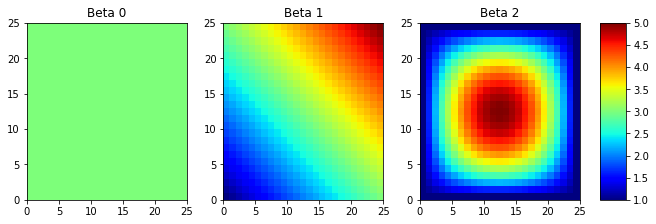

In [8]:
#2.Draw figures of different heterogeneity surfaces           
fig = plt.figure(figsize=(9,3),constrained_layout=True)
gs = GridSpec(1, 3, figure=fig)
jet  = plt.get_cmap('jet',256)
psm =0        
for col in range(3):
    beta_cur = "Beta {:d}".format(col)
    ax = fig.add_subplot(gs[0,col],title = beta_cur)
    psm = ax.pcolormesh(beta[col], cmap=jet, rasterized=True, vmin=beta_min, vmax=beta_max)
fig.colorbar(psm, ax = fig.axes[2])
plt.show()

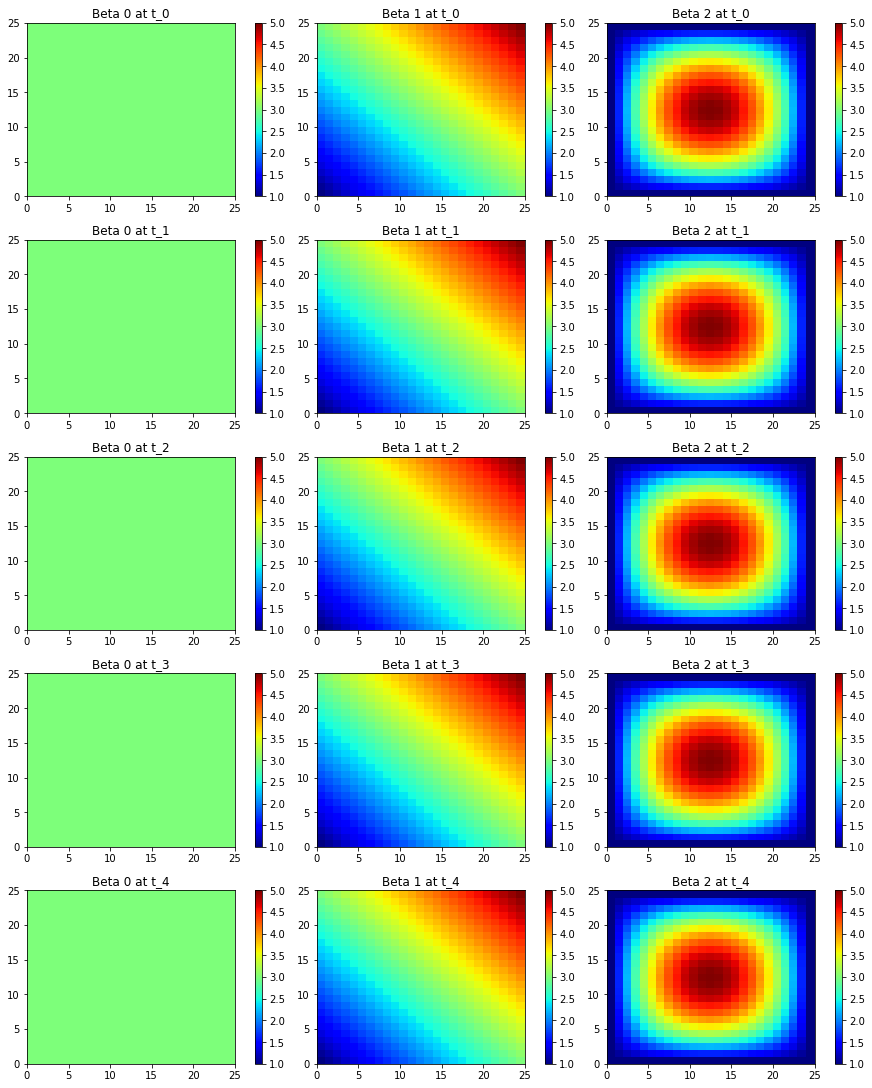

In [9]:
#draw the cofficients surfaces of different time stages.
fig_time = plt.figure(figsize=(12,3*kticks),constrained_layout=True)
gs_time = GridSpec(kticks, 3, figure=fig_time)
jet  = plt.get_cmap('jet',256)
psm_time =0

for row in range(kticks): 
    str_curt = "t_{:d}".format(row)
    for col in range(3):
        beta_cur = "Beta {:d}".format(col)
        title_str = beta_cur+" at "+ str_curt
        ax_time = fig_time.add_subplot(gs_time[row,col],title = title_str)
        psm_time = ax_time.pcolormesh(beta_change[row,col], cmap=jet, rasterized=True, vmin=beta_min_list[row], vmax=beta_max_list[row])
        fig_time.colorbar(psm_time, ax = ax_time)
plt.show()

In [10]:
# mean and standard deviation of errors (noises)
mu_err, sigma_err = 0, 0.5 
err = np.random.normal(mu_err, sigma_err, kticks*625*1)
err = err.reshape((kticks,625,1))

In [11]:
# mean and standard deviation of independent variable X1
mu_X1, sigma_X1 = 100,8
X1 = np.zeros((kticks,625,1))

In [12]:
# mean and standard deviation of independent variable X2
mu_X2, sigma_X2 = 50, 6
X2 = np.zeros((kticks,625,1))
X =  np.zeros((kticks,625,2))

y = np.ones((kticks,625,1))
uc =np.arange(625);
vc= np.arange(625);
for i in range(25):
    for j in range(25):
        uc[25*i+j]=i
        vc[25*i+j]=j
all_coords = np.array(list(zip(pd.Series(uc),pd.Series(vc))))

In [13]:
#Sample form the generated surfaces for tests.
np.random.seed(1000)

sample_num = 333#1000
samples_ticks = np.ones(sample_num)
samples_ticks = np.array_split(samples_ticks, kticks, axis = 0)
mask_ticks_list =[]
cal_coords_list =[]
cal_y_list = []
cal_X_list = []
pre_coords_list = []
Pre_y_list = []
Pre_X_list = []
Pre_deta_t=1

In [14]:
for i in range(kticks):    
    # variation of mean and standard deviation over time
    mu_X1_tick = mu_X1 +  np.random.choice((-1,1))*0.5*delt_stwr_intervel[i]*i
    sigma_X1_tick = sigma_X1 
    X1_tick = np.random.normal(mu_X1_tick, sigma_X1_tick, 625)
    X1_tick = np.reshape(X1_tick,(1,25,25))    
#case2    
    mu_X2_tick  = mu_X2  +  np.random.choice((-1,1))*2*delt_stwr_intervel[i]*i
#case2
    sigma_X2_tick = sigma_X2
    X2_tick = np.random.normal(mu_X2_tick, sigma_X2_tick, 625)
    X2_tick = np.reshape(X2_tick,(1,25,25))  
    
#case 2       
    Values_change_trend(X1_tick,1,cur_tick = 0,deta_t = delt_stwr_intervel[i],sita = 0.5,power = 2)
    Values_change_trend(X2_tick,2,cur_tick = 0,deta_t = delt_stwr_intervel[i],sita = 1,power = 1) 
#case 2     
    X1_tick = np.reshape(X1_tick,(1,625,1))
    X2_tick = np.reshape(X2_tick,(1,625,1))
    X_tick = X1_tick.copy()
    X_tick = np.dstack((X_tick,X2_tick))
    X[i] = X_tick  
    #There also exists the heterogeneity of X in space. And the X value also change through time.  
    
    tick_sam_num = len(samples_ticks[i])
    samples_ticks[i] = np.random.choice(range(625),tick_sam_num,replace=False)
    mask_ticks = np.ones_like(y[i],dtype=bool).flatten() 
    mask_ticks[samples_ticks[i]] = False
    mask_ticks_list.append(mask_ticks)
    cal_coords_tick = all_coords[~mask_ticks]
    cal_coords_list.append(cal_coords_tick)
    cal_y_tick = y[i,~mask_ticks]
    cal_X_tick = X[i,~mask_ticks]
    cal_X_list.append(cal_X_tick)
    for j in range(tick_sam_num):
         uu_tick =  cal_coords_tick[j,0]
         vv_tick =  cal_coords_tick[j,1]
         cal_y_tick[j] = beta_change[i,0,uu_tick,vv_tick]+beta_change[i,1,uu_tick,vv_tick]*cal_X_tick[j,0] + beta_change[i,2,uu_tick,vv_tick]*cal_X_tick[j,1] + err[i,j]
    cal_y_list.append(cal_y_tick)
    pred_coords_tick = all_coords[mask_ticks]
    pred_y_tick = y[i,mask_ticks]
    pred_X_tick = X[i,mask_ticks]
    left_nums =len(all_coords)-tick_sam_num
    for j in range(left_nums):
         uu_tick_pre =  pred_coords_tick[j,0]
         vv_tick_pre =  pred_coords_tick[j,1]
         pred_y_tick[j] = beta_change[i,0,uu_tick_pre,vv_tick_pre]+beta_change[i,1,uu_tick_pre,vv_tick_pre]*pred_X_tick[j,0] +beta_change[i,2,uu_tick_pre,vv_tick_pre]*pred_X_tick[j,1] + err[i,j]   
    pre_coords_list.append(pred_coords_tick)
    Pre_y_list.append(pred_y_tick)
    Pre_X_list.append(pred_X_tick)
#output these samples for model test on GTWR (Huang 2010,2014)
   
for i in range(kticks):
    dataframe = pd.DataFrame({'cal_y':cal_y_list[i][:,0].tolist(),'cal_x1':cal_X_list[i][:,0].tolist(),'cal_x2':cal_X_list[i][:,1].tolist(),'cal_coordsX':cal_coords_list[i][:,0].tolist(),'cal_coordsY':cal_coords_list[i][:,1].tolist()})
    dataframe.to_csv("C:/Users/65532/Desktop/stwr_test/outfile_{:d}.csv".format(i)) 
dataframe =  pd.DataFrame({'time_stamp':tick_times[:,0].tolist()})    
dataframe.to_csv("C:/Users/65532/Desktop/stwr_test/time_stamp.csv") 

In [ ]:
#################################################Comparision of GWR and STWR ################################################################
#Output of GWR
gwr_bw_ticks_list = []
gwr_results_list = [] 
gwr_models_list = []  
for i in range(kticks):   
    gwr_selector_ticks = Sel_BW(cal_coords_list[i], cal_y_list[i], cal_X_list[i])
    gwr_bw_ticks = gwr_selector_ticks.search(bw_min=2)
    gwr_bw_ticks_list.append(gwr_bw_ticks)
    gwr_model = GWR(cal_coords_list[i], cal_y_list[i], cal_X_list[i], gwr_bw_ticks)
    gwr_results = gwr_model.fit()
    gwr_models_list.append(gwr_model)
    gwr_results_list.append(gwr_results)
    str_curt = "current results at time stage t_{:d}".format(i)
    print(str_curt)
    print(gwr_results.summary())   

current results at time stage t_0
Model type                                                         Gaussian
Number of observations:                                                  67
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         760901.148
Log-likelihood:                                                    -407.877
AIC:                                                                821.755
AICc:                                                               824.400
BIC:                                                             760632.048
R2:                                                                   0.036
Adj. R2:                                                              0.006

Variable                              Est.         SE  t(Est/SE)    p-value
--------------------------

In [ ]:
y_lasttrue = None
gwr_predresults =None
draw_vals_gwr_list=[]

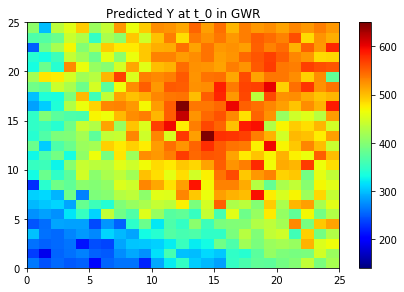

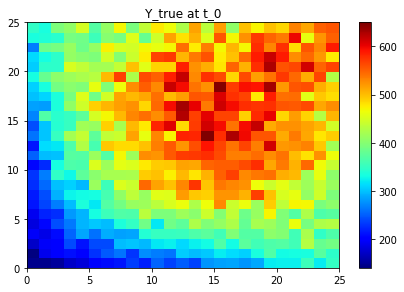

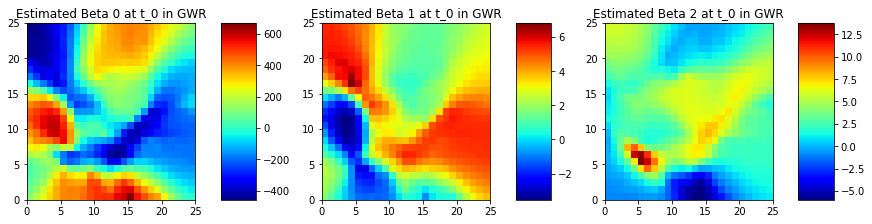

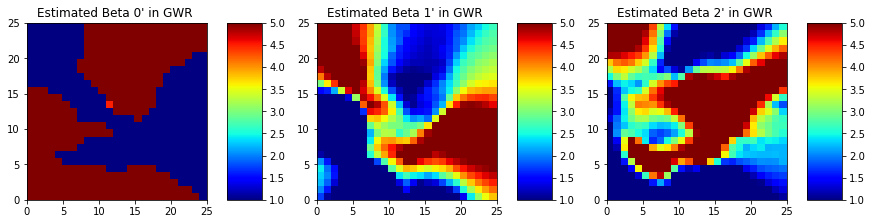

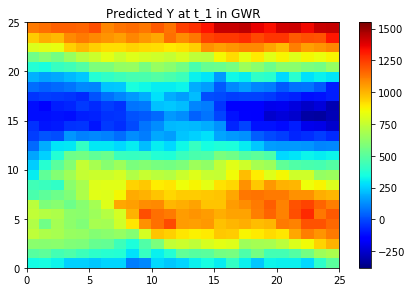

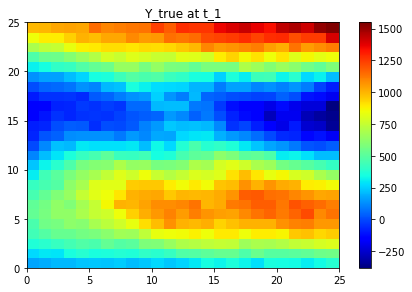

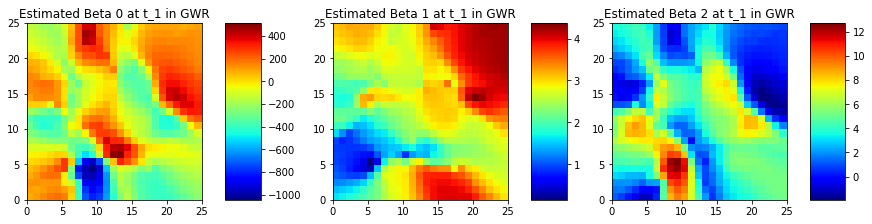

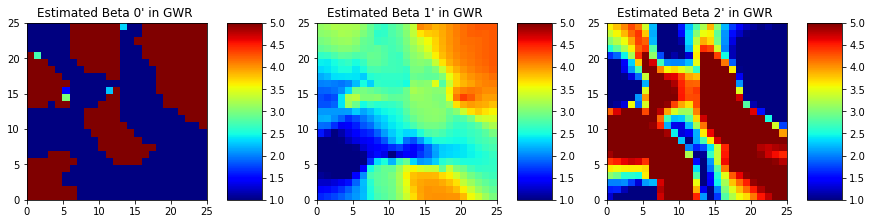

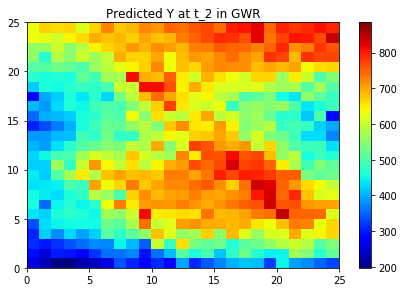

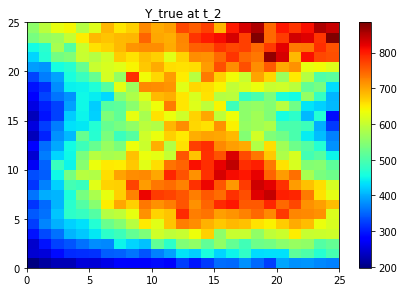

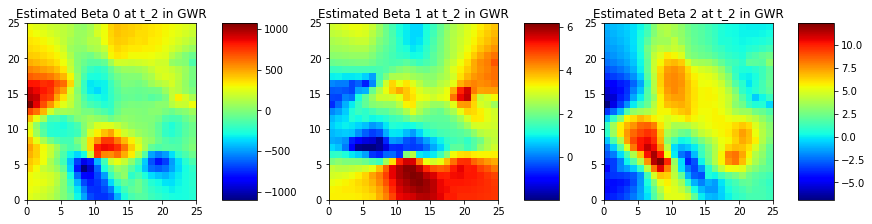

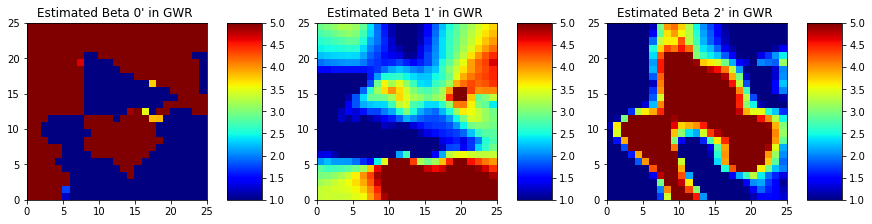

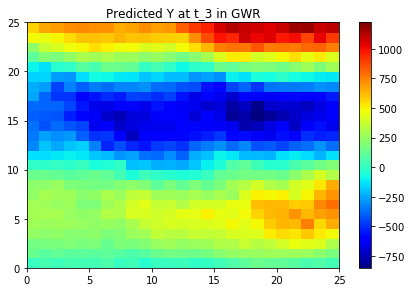

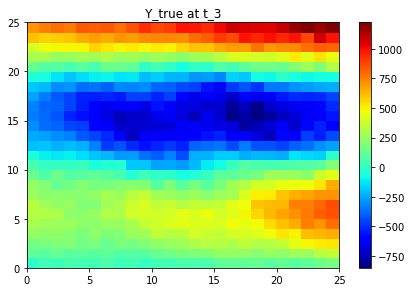

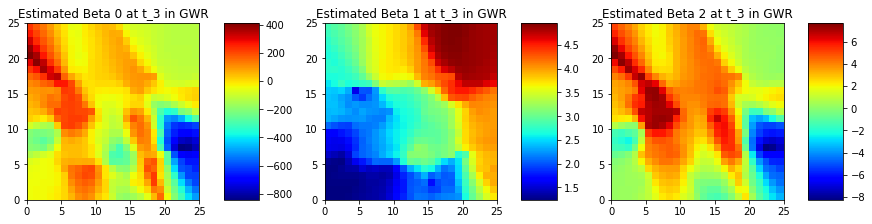

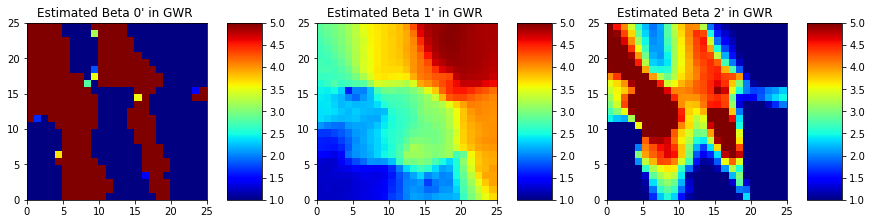

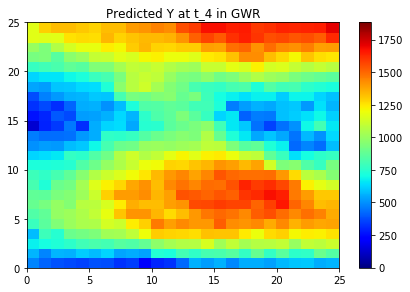

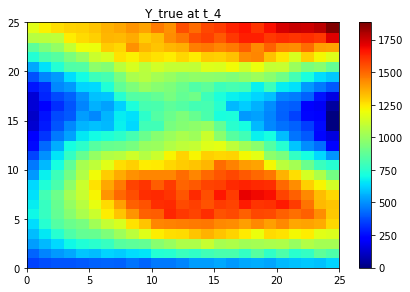

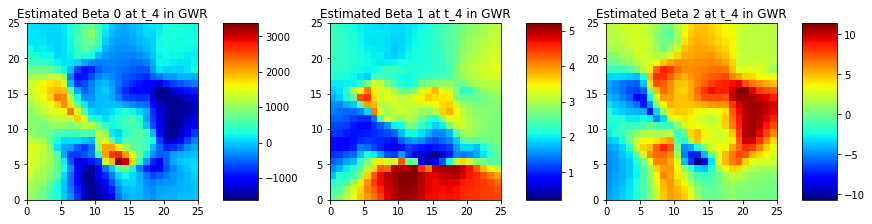

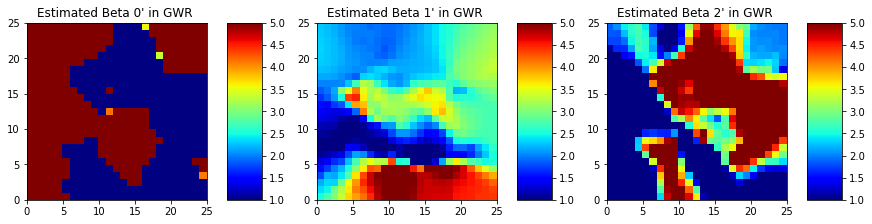

In [ ]:
for i in range(kticks):
       gwr_scale_tick = gwr_results_list[i].scale 
       gwr_residuals_tick = gwr_results_list[i].resid_response
       alllen = len(all_coords)
       allklen = cal_X_list[i].shape[1]+1
       rec_parmas = np.ones((alllen,allklen))
       calen =  len(cal_y_list[i])
       prelen = len(Pre_X_list[i])
       gwr_cal_parmas = np.reshape(gwr_results_list[i].params.flatten(),(-1,allklen))
       gwr_pre_parmas = np.ones((prelen,allklen))
       if (calen>=prelen):
           pred_gwr_dir_result = gwr_models_list[i].predict(pre_coords_list[i],Pre_X_list[i],gwr_scale_tick,gwr_residuals_tick)
           pre_y_gwr = pred_gwr_dir_result.predictions 
           pre_parmas_gwr=np.reshape(pred_gwr_dir_result.params.flatten(),(-1,allklen)) 
       else:
            spl_parts = math.ceil(prelen*1.0/calen) 
            spl_X = np.array_split(Pre_X_list[i], spl_parts, axis = 0)
            spl_coords = np.array_split(pre_coords_list[i], spl_parts, axis = 0)
            pred_gwr_result = np.array_split(Pre_y_list[i], spl_parts, axis = 0)
            pred_parmas_result = np.array_split(gwr_pre_parmas, spl_parts, axis = 0)
            for j in range(spl_parts):
                pred_gwr_spl_result =  gwr_models_list[i].predict(spl_coords[j],spl_X[j],gwr_scale_tick,gwr_residuals_tick)
                pred_gwr_result[j] =pred_gwr_spl_result.predictions 
                pred_parmas_result[j] =np.reshape(pred_gwr_spl_result.params.flatten(),(-1,allklen))
#            pre_y_gwr = pred_gwr_result[0]
#            pre_parmas_gwr = pred_parmas_result[0]
#            combnum = spl_parts-1
#            for s in range(combnum):
#                pre_y_gwr = np.vstack((pre_y_gwr,pred_gwr_result[s+1]))
#                pre_parmas_gwr = np.vstack((pre_parmas_gwr,pred_parmas_result[s+1]))
            pre_y_gwr = pred_gwr_result[0]
            pre_parmas_gwr = pred_parmas_result[0]
            combnum = spl_parts-1
            for s in range(combnum):
                   pre_y_gwr = np.vstack((pre_y_gwr,pred_gwr_result[s+1]))
                   pre_parmas_gwr = np.vstack((pre_parmas_gwr,pred_parmas_result[s+1]))
#prediction surfaces
       draw_vals_gwr = np.ones([25,25])
       draw_gwr_parms = np.ones([3,25,25])
       for j in range(prelen):
            draw_vals_gwr[pre_coords_list[i][j,0],pre_coords_list[i][j,1]]=pre_y_gwr[j]       
            draw_gwr_parms[0,pre_coords_list[i][j,0],pre_coords_list[i][j,1]]=pre_parmas_gwr[j,0]
            draw_gwr_parms[1,pre_coords_list[i][j,0],pre_coords_list[i][j,1]]=pre_parmas_gwr[j,1]
            draw_gwr_parms[2,pre_coords_list[i][j,0],pre_coords_list[i][j,1]]=pre_parmas_gwr[j,2]      
       for j in range(calen):
            draw_vals_gwr[cal_coords_list[i][j,0],cal_coords_list[i][j,1]]=cal_y_list[i][j]      
            draw_gwr_parms[0,cal_coords_list[i][j,0],cal_coords_list[i][j,1]]=gwr_cal_parmas[j,0]
            draw_gwr_parms[1,cal_coords_list[i][j,0],cal_coords_list[i][j,1]]=gwr_cal_parmas[j,1]
            draw_gwr_parms[2,cal_coords_list[i][j,0],cal_coords_list[i][j,1]]=gwr_cal_parmas[j,2]        
#store the data for calculating the time distance later.
       draw_vals_gwr_list.append(draw_vals_gwr)
#surface of Y_true.
       y_true = np.ones((625,1))
       for j in range(625):
             ss = all_coords[j,0]
             tt=  all_coords[j,1]
             y_true[j] = beta_change[i,0,ss,tt]+ beta_change[i,1,ss,tt]*X[i,j,0] + beta_change[i,2,ss,tt]*X[i,j,1] +err[i,j]         
       ymin = np.amin(y_true) -1
       ymax = np.amax(y_true)  +1
       y_true = np.reshape(y_true,(25,25))       
       fig_pre, ax = plt.subplots()
       psm = ax.pcolormesh(draw_vals_gwr, cmap=jet, rasterized=True, vmin=ymin, vmax=ymax)
       fig_pre.colorbar(psm, ax=ax)
       fig_pre.tight_layout()
       plt.title("Predicted Y at t_{:d} in GWR".format(i))
       plt.show()
        
       fig_pre3, ax3 = plt.subplots()
       psm3 = ax3.pcolormesh(y_true, cmap=jet, rasterized=True, vmin=ymin, vmax=ymax)
       fig_pre3.colorbar(psm3, ax=ax3)
       fig_pre3.tight_layout()
       plt.title("Y_true at t_{:d}".format(i))
       plt.show()
#Three coefficient surfaces predicted by GWR with using their beta color bar
       beta_cur0 = "Estimated Beta 0 at t_{:d} in GWR".format(i)
       beta_cur1 = "Estimated Beta 1 at t_{:d} in GWR".format(i)
       beta_cur2 = "Estimated Beta 2 at t_{:d} in GWR".format(i)

       fig_parmas_gwr = plt.figure(figsize=(12,3),constrained_layout=True)
       gs_gwr = GridSpec(1, 3, figure=fig_parmas_gwr)
       jet  = plt.get_cmap('jet',256)
       psm_pam_gwr =0        
       #for col in range(3):
       #         ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,col])
       #          psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[col], cmap=jet, rasterized=True, vmin=beta_min_list[i], vmax=beta_max_list[i])
       #          fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)       
       vmin0 = np.amin(draw_gwr_parms[0])
       vmax0 = np.amax(draw_gwr_parms[0])
       vmin1 = np.amin(draw_gwr_parms[1])
       vmax1 = np.amax(draw_gwr_parms[1])
       vmin2 = np.amin(draw_gwr_parms[2])
       vmax2 = np.amax(draw_gwr_parms[2])
       ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,0],title= beta_cur0)
       psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[0], cmap=jet, rasterized=True, vmin= vmin0, vmax= vmax0)
       fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)        
       ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,1],title= beta_cur1)
       psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[1], cmap=jet, rasterized=True, vmin= vmin1, vmax = vmax1)
       fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)  
       ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,2],title= beta_cur2)
       psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[2], cmap=jet, rasterized=True,vmin= vmin2, vmax = vmax2)
       fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)
       plt.show()
       
#Three coefficient surfaces predicted by GWR with using the ture beta color bar
       fig_parmas_gwr = plt.figure(figsize=(12,3),constrained_layout=True)
       gs_gwr = GridSpec(1, 3, figure=fig_parmas_gwr)
       jet  = plt.get_cmap('jet',256)
       psm_pam_gwr =0        
       for ccol in range(3):
                 ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,ccol],title = "Estimated Beta {:d}' in GWR ".format(ccol))
                 psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[ccol], cmap=jet, rasterized=True, vmin=beta_min_list[i], vmax=beta_max_list[i])
                 fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)   
    
       if(i == (kticks-1)):
               y_lasttrue = y_true
               gwr_predresults =draw_vals_gwr

In [ ]:
delta_y_values = []
delta_y_value_tick = draw_vals_gwr_list[0]
for i in range(kticks):
     delta_y_tick= draw_vals_gwr_list[i]-delta_y_value_tick
     delta_y_value_tick=draw_vals_gwr_list[i]
     delta_y_values.append(delta_y_tick)
delta_x_values = []
delta_x_value_tick =  np.ones((25,25))*np.mean(cal_X_list[0])
for i in range(kticks):
     tick_mean = np.ones((25,25))*np.mean(cal_X_list[i])
     delta_x_tick = tick_mean-delta_x_value_tick
     delta_x_value_tick =tick_mean 
     delta_x_values.append(delta_x_tick)
gwr_bw0  = gwr_bw_ticks_list[-1]   
stwr_selector_ = Sel_Spt_BW(cal_coords_list, cal_y_list, cal_X_list,delt_stwr_intervel)

optalpha,optsita,opt_btticks,opt_gwr_bw0 = stwr_selector_.search() 
stwr_model = STWR(cal_coords_list,cal_y_list,cal_X_list,delt_stwr_intervel,optsita,opt_gwr_bw0,tick_nums=opt_btticks+1,alpha =optalpha,recorded = 1)
stwr_results = stwr_model.fit()
print(stwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 333
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        4920657.289
Log-likelihood:                                                    -463.887
AIC:                                                                933.774
AICc:                                                               936.429
BIC:                                                            4920393.341
R2:                                                                   0.478
Adj. R2:                                                              0.461

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
stwr_scale = stwr_results.scale 
stwr_residuals = stwr_results.resid_response
alllen_stwr = len(all_coords)
allklen_stwr = cal_X_list[i].shape[1]+1
rec_parmas_stwr = np.ones((alllen_stwr,allklen_stwr))
calen_stwr =  len(cal_y_list[-1])
prelen_stwr = len(Pre_X_list[-1])
stwr_cal_parmas = np.reshape(stwr_results.params.flatten(),(-1,allklen_stwr))
stwr_pre_parmas = np.ones((prelen_stwr,allklen_stwr))
if (calen_stwr>=prelen_stwr):
       predPointList = [pre_coords_list[-1]]
       PreX_list = [Pre_X_list[-1]]
       pred_stwr_dir_result = stwr_model.predict(predPointList,PreX_list,stwr_scale,stwr_residuals)
       pre_y_stwr = pred_stwr_dir_result.predictions 
       pre_parmas_stwr=np.reshape(pred_stwr_dir_result.params.flatten(),(-1,allklen_stwr)) 
else:
        spl_parts_stwr = math.ceil(prelen_stwr*1.0/calen_stwr) 
        spl_X_stwr = np.array_split(Pre_X_list[-1], spl_parts_stwr, axis = 0)
        spl_coords_stwr = np.array_split(pre_coords_list[-1], spl_parts_stwr, axis = 0)
        pred_stwr_result = np.array_split(Pre_y_list[-1], spl_parts_stwr, axis = 0)
        pred_stwrparmas_result = np.array_split(stwr_pre_parmas, spl_parts_stwr, axis = 0)
        for j in range(spl_parts_stwr):
                predPointList_tick = [spl_coords_stwr[j]]
                PreX_list_tick = [spl_X_stwr[j]]
                pred_stwr_spl_result =  stwr_model.predict(predPointList_tick,PreX_list_tick,stwr_scale,stwr_residuals)
                pred_stwr_result[j] =pred_stwr_spl_result.predictions 
                pred_stwrparmas_result[j] =np.reshape(pred_stwr_spl_result.params.flatten(),(-1,allklen_stwr))
        pre_y_stwr = pred_stwr_result[0]
        pre_parmas_stwr = pred_stwrparmas_result[0]
        combnum = spl_parts_stwr-1
        for s in range(combnum):
            pre_y_stwr = np.vstack((pre_y_stwr,pred_stwr_result[s+1]))
            pre_parmas_stwr = np.vstack((pre_parmas_stwr,pred_stwrparmas_result[s+1]))

draw_vals_stwr = np.ones([25,25])
draw_stwr_parms = np.ones([3,25,25])
for j in range(prelen_stwr):
        draw_vals_stwr[pre_coords_list[-1][j,0],pre_coords_list[-1][j,1]]=pre_y_stwr[j]       
        draw_stwr_parms[0,pre_coords_list[-1][j,0],pre_coords_list[-1][j,1]]=pre_parmas_stwr[j,0]
        draw_stwr_parms[1,pre_coords_list[-1][j,0],pre_coords_list[-1][j,1]]=pre_parmas_stwr[j,1]
        draw_stwr_parms[2,pre_coords_list[-1][j,0],pre_coords_list[-1][j,1]]=pre_parmas_stwr[j,2]      
for j in range(calen_stwr):
        draw_vals_stwr[cal_coords_list[-1][j,0],cal_coords_list[-1][j,1]]=cal_y_list[-1][j]      
        draw_stwr_parms[0,cal_coords_list[-1][j,0],cal_coords_list[-1][j,1]]=stwr_cal_parmas[j,0]
        draw_stwr_parms[1,cal_coords_list[-1][j,0],cal_coords_list[-1][j,1]]=stwr_cal_parmas[j,1]
        draw_stwr_parms[2,cal_coords_list[-1][j,0],cal_coords_list[-1][j,1]]=stwr_cal_parmas[j,2] 

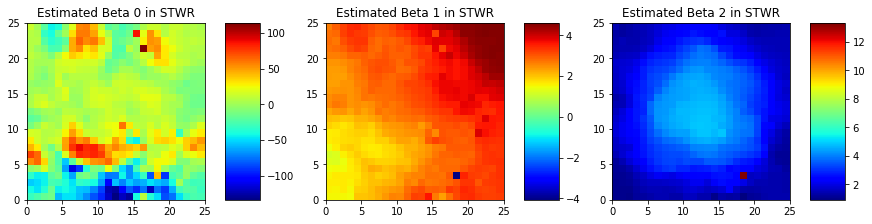

In [ ]:
#Three coefficient surfaces predicted by STWR with using their self color bar
fig_parmas_stwr = plt.figure(figsize=(12,3),constrained_layout=True)
gs_stwr = GridSpec(1, 3, figure=fig_parmas_stwr)
jet  = plt.get_cmap('jet',256)
psm_pam_stwr =0        
#for col in range(3):
#        ax_pam_stwr = fig_parmas_stwr.add_subplot(gs_stwr[0,col])
#        psm_pam_stwr = ax_pam_stwr.pcolormesh(draw_stwr_parms[col], cmap=jet, rasterized=True, vmin=beta_min_list[i], vmax=beta_max_list[i])
#        fig_parmas_stwr.colorbar(psm_pam_stwr, ax = ax_pam_stwr)
        
vmin0 = np.amin(draw_stwr_parms[0])
vmax0 = np.amax(draw_stwr_parms[0])
vmin1 = np.amin(draw_stwr_parms[1])
vmax1 = np.amax(draw_stwr_parms[1])
vmin2 = np.amin(draw_stwr_parms[2])
vmax2 = np.amax(draw_stwr_parms[2])

ax_pam_stwr = fig_parmas_stwr.add_subplot(gs_stwr[0,0],title= "Estimated Beta 0 in STWR")
psm_pam_stwr = ax_pam_stwr.pcolormesh(draw_stwr_parms[0], cmap=jet, rasterized=True, vmin= vmin0, vmax= vmax0)
fig_parmas_stwr.colorbar(psm_pam_stwr, ax = ax_pam_stwr)

ax_pam_stwr = fig_parmas_stwr.add_subplot(gs_stwr[0,1],title= "Estimated Beta 1 in STWR")
psm_pam_stwr = ax_pam_stwr.pcolormesh(draw_stwr_parms[1], cmap=jet, rasterized=True, vmin= vmin1, vmax = vmax1)
fig_parmas_stwr.colorbar(psm_pam_stwr, ax = ax_pam_stwr)

ax_pam_stwr = fig_parmas_stwr.add_subplot(gs_stwr[0,2],title= "Estimated Beta 2 in STWR")
psm_pam_stwr = ax_pam_stwr.pcolormesh(draw_stwr_parms[2], cmap=jet, rasterized=True,vmin= vmin2, vmax = vmax2)
fig_parmas_stwr.colorbar(psm_pam_stwr, ax = ax_pam_stwr)
plt.show()

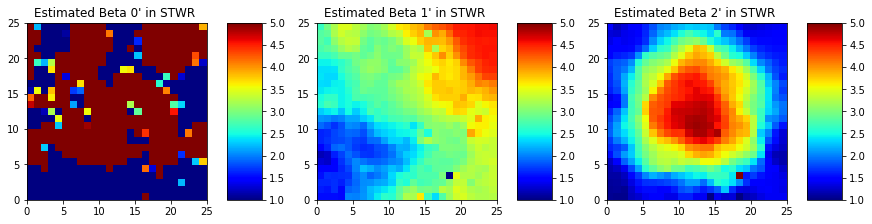

In [ ]:
#Three coefficient surfaces predicted by STWR using the ture beta color bar
fig_parmas_stwr = plt.figure(figsize=(12,3),constrained_layout=True)
gs_stwr = GridSpec(1, 3, figure=fig_parmas_stwr)
jet  = plt.get_cmap('jet',256)
psm_pam_stwr =0        
for ccol in range(3):
        ax_pam_stwr = fig_parmas_stwr.add_subplot(gs_stwr[0,ccol],title = "Estimated Beta {:d}' in STWR ".format(ccol))
        psm_pam_stwr = ax_pam_stwr.pcolormesh(draw_stwr_parms[ccol], cmap=jet, rasterized=True, vmin=beta_min_list[i], vmax=beta_max_list[i])
        fig_parmas_stwr.colorbar(psm_pam_stwr, ax = ax_pam_stwr)
plt.show()

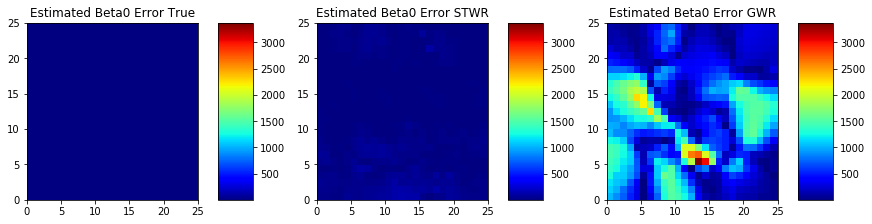

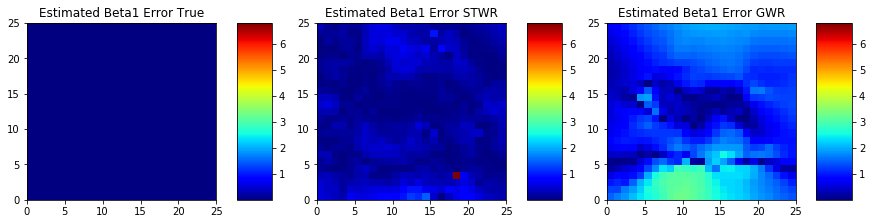

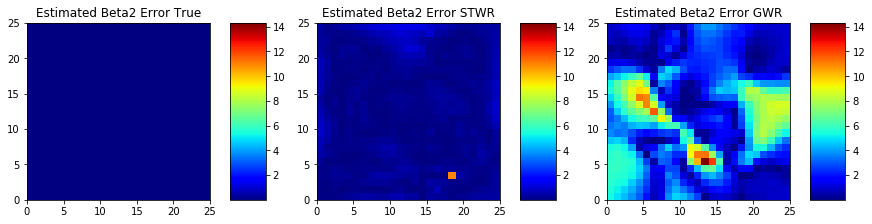

In [ ]:
#draw surfaces of beta errors for GWR and STWR    
for col in range(3):
    beta_cur = "Estimated Beta{:d} Error".format(col)
    beta_err_true = np.abs(beta_change[4,col]- beta_change[4,col])
    beta_pre_stwr_err = np.abs(beta_change[4,col]- draw_stwr_parms[col]) 
    bteta_pre_gwr_err = np.abs(beta_change[4,col]- draw_gwr_parms[col])
    
    vmin1  =np.amin(beta_pre_stwr_err)
    vmin2  =np.amin(bteta_pre_gwr_err)
    if(vmin1 <vmin2):
        vmin_stwr_err=vmin1
    else:
        vmin_stwr_err= vmin2
    vmax1 = np.amax(beta_pre_stwr_err)
    vmax2 = np.amax(bteta_pre_gwr_err)
    if(vmax1 >vmax2):
        vmax_stwr_err=vmax1
    else:
        vmax_stwr_err= vmax2

   # if (vmax_stwr_err>vmax_stwr):
  #          vmax_stwr_err = vmax_stwr
    beta_cur0 = beta_cur + " True"
    beta_cur1 = beta_cur + " STWR"
    beta_cur2 = beta_cur + " GWR"
    
    fig_beta_err = plt.figure(figsize=(12,3),constrained_layout=True)
    gs_beta_err = GridSpec(1, 3, figure=fig_beta_err)
    jet  = plt.get_cmap('jet',256)
    ax_berr = fig_beta_err.add_subplot(gs_beta_err[0,0],title= beta_cur0)
    beta_err = ax_berr.pcolormesh(beta_err_true, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err) 
    fig_beta_err.colorbar(beta_err, ax = ax_berr)
    ax_berr = fig_beta_err.add_subplot(gs_beta_err[0,1],title= beta_cur1)
    beta_err = ax_berr.pcolormesh(beta_pre_stwr_err, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err) 
    fig_beta_err.colorbar(beta_err, ax = ax_berr)
    ax_berr = fig_beta_err.add_subplot(gs_beta_err[0,2],title = beta_cur2)
    beta_err = ax_berr.pcolormesh(bteta_pre_gwr_err, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err) 
    fig_beta_err.colorbar(beta_err, ax = ax_berr)
    plt.show()

    
 #fig_parmas_gwr = plt.figure(figsize=(12,3),constrained_layout=True)
  #     gs_gwr = GridSpec(1, 3, figure=fig_parmas_gwr)
 #      jet  = plt.get_cmap('jet',256)
 #      psm_pam_gwr =0        
       #for col in range(3):
       #         ax_pam_gwr = fig_parmas_gwr.add_subplot(gs_gwr[0,col])
       #          psm_pam_gwr = ax_pam_gwr.pcolormesh(draw_gwr_parms[col], cmap=jet, rasterized=True, vmin=beta_min_list[i], vmax=beta_max_list[i])
       #          fig_parmas_gwr.colorbar(psm_pam_gwr, ax = ax_pam_gwr)  
  

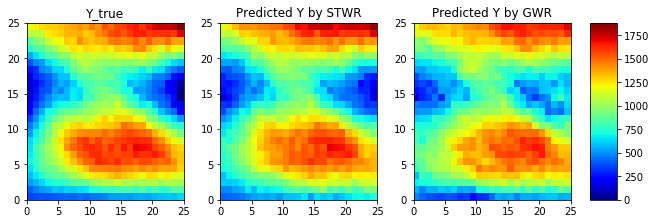

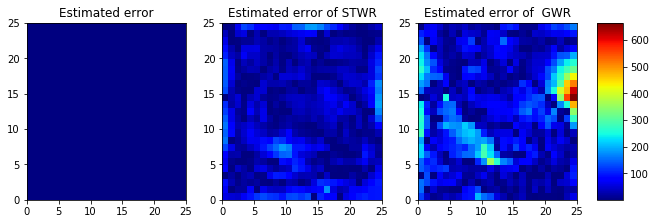

In [ ]:
#Comparision surfaces of Y_true,prdictions surface by GWR and STWR.      
fig_pred_cmp_stwr = plt.figure(figsize=(9,3),constrained_layout=True)
gs_stwr = GridSpec(1, 3, figure=fig_pred_cmp_stwr)
jet  = plt.get_cmap('jet',256)
vmin_stwr=np.amin(y_true)
vmax_stwr=np.amax(y_true)

ax_true  = fig_pred_cmp_stwr.add_subplot(gs_stwr[0,0],title= "Y_true")
psm_true = ax_true.pcolormesh(y_true, cmap=jet, rasterized=True, vmin=vmin_stwr, vmax=vmax_stwr)
ax_stwr  = fig_pred_cmp_stwr.add_subplot(gs_stwr[0,1],title= "Predicted Y by STWR")
psm_stwr = ax_stwr.pcolormesh(draw_vals_stwr, cmap=jet, rasterized=True, vmin=vmin_stwr, vmax=vmax_stwr)
ax_gwr  =  fig_pred_cmp_stwr.add_subplot(gs_stwr[0,2],title= "Predicted Y by GWR")
psm_gwr =  ax_gwr.pcolormesh(gwr_predresults, cmap=jet, rasterized=True, vmin=vmin_stwr, vmax=vmax_stwr)

fig_pred_cmp_stwr.colorbar(psm_true, ax = fig_pred_cmp_stwr.axes[2])
plt.show()

y_self_err = np.abs(y_true-y_true)
y_pre_stwr_err = np.abs(y_true- draw_vals_stwr) 
y_pre_gwr_err = np.abs(y_true-gwr_predresults)

fig_prederr_cmp_stwr = plt.figure(figsize=(9,3),constrained_layout=True)
gs_stwr_err = GridSpec(1, 3, figure=fig_prederr_cmp_stwr)
jet  = plt.get_cmap('jet',256)

vmin1  =np.amin(y_pre_stwr_err)
vmin2  =np.amin(y_pre_gwr_err)
if(vmin1 <vmin2):
    vmin_stwr_err=vmin1
else:
    vmin_stwr_err= vmin2
vmax1 = np.amax(y_pre_stwr_err)
vmax2 = np.amax(y_pre_gwr_err)
if(vmax1 >vmax2):
    vmax_stwr_err=vmax1
else:
    vmax_stwr_err= vmax2

if (vmax_stwr_err>vmax_stwr):
        vmax_stwr_err = vmax_stwr

ax_true_err  = fig_prederr_cmp_stwr.add_subplot(gs_stwr_err[0,0],title = "Estimated error")
psm_true_err = ax_true_err.pcolormesh(y_self_err, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err)
ax_stwr_err  = fig_prederr_cmp_stwr.add_subplot(gs_stwr_err[0,1],title = "Estimated error of STWR")
psm_stwr_err = ax_stwr_err.pcolormesh(y_pre_stwr_err, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err)
ax_gwr_err  =  fig_prederr_cmp_stwr.add_subplot(gs_stwr_err[0,2],title = "Estimated error of  GWR")
psm_gwr_err =  ax_gwr_err.pcolormesh(y_pre_gwr_err, cmap=jet, rasterized=True, vmin=vmin_stwr_err, vmax=vmax_stwr_err)

fig_prederr_cmp_stwr.colorbar(psm_true_err, ax = fig_prederr_cmp_stwr.axes[2])
plt.show()